# JEE Cutoff Prediction Model
## Phase 2: Feature Engineering

**Objective**: Create features from cleaned data to train the XGBoost model

**Key Tasks**:
- Create lag features (previous year cutoffs)
- Encode categorical variables
- Compute aggregate statistics
- Create derived features

**Course Alignment**: Unit 3 - Data Preprocessing & Feature Engineering

## Step 1: Import Libraries and Load Cleaned Data

In [106]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [107]:
# Load cleaned data from Phase 1
df = pd.read_csv('cutoffs_cleaned.csv')

print("✅ Cleaned data loaded successfully!")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"📅 Years: {df['year'].min()} to {df['year'].max()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head(10)

✅ Cleaned data loaded successfully!
📊 Shape: 73523 rows × 7 columns
📅 Years: 2018 to 2025

Columns: ['year', 'institute', 'branch', 'quota', 'seat_type', 'gender', 'cutoff']

First few rows:


,year,institute,branch,quota,seat_type,gender,cutoff
0,2018,"Assam University, Silchar",AG,AI,OBC-NCL,Female-only (including Supernumerary),20319.0
1,2018,"Assam University, Silchar",AG,AI,OBC-NCL,Gender-Neutral,17411.0
2,2018,"Assam University, Silchar",AG,AI,OPEN,Female-only (including Supernumerary),56345.0
3,2018,"Assam University, Silchar",AG,AI,OPEN,Gender-Neutral,57812.0
4,2018,"Assam University, Silchar",AG,AI,OPEN (PwD),Gender-Neutral,2247.0
5,2018,"Assam University, Silchar",AG,AI,SC,Gender-Neutral,10992.0
6,2018,"Assam University, Silchar",AG,AI,ST,Gender-Neutral,5176.0
7,2018,"Assam University, Silchar",AG,HS,OBC-NCL,Gender-Neutral,193316.0
8,2018,"Assam University, Silchar",AG,HS,SC,Female-only (including Supernumerary),32976.0
9,2018,"Assam University, Silchar",AG,HS,SC,Gender-Neutral,26664.0


## Step 2: Create Unique Identifier for Each Seat

Create a composite key to identify unique seat combinations (institute + branch + quota + seat_type + gender)

In [108]:
# Create a unique identifier for each seat combination
df['seat_id'] = (df['institute'] + '_' + 
                 df['branch'] + '_' + 
                 df['quota'] + '_' + 
                 df['seat_type'] + '_' + 
                 df['gender'])

print("✅ Seat ID created successfully!")
print(f"\n📊 Total unique seat combinations: {df['seat_id'].nunique():,}")
print(f"\nExample seat IDs:")
print(df[['institute', 'branch', 'quota', 'seat_type', 'gender', 'seat_id']].head())

✅ Seat ID created successfully!

📊 Total unique seat combinations: 12,636

Example seat IDs:
                   institute branch quota   seat_type  \
0  Assam University, Silchar     AG    AI     OBC-NCL   
1  Assam University, Silchar     AG    AI     OBC-NCL   
2  Assam University, Silchar     AG    AI        OPEN   
3  Assam University, Silchar     AG    AI        OPEN   
4  Assam University, Silchar     AG    AI  OPEN (PwD)   

                                  gender  \
0  Female-only (including Supernumerary)   
1                         Gender-Neutral   
2  Female-only (including Supernumerary)   
3                         Gender-Neutral   
4                         Gender-Neutral   

                                             seat_id  
0  Assam University, Silchar_AG_AI_OBC-NCL_Female...  
1  Assam University, Silchar_AG_AI_OBC-NCL_Gender...  
2  Assam University, Silchar_AG_AI_OPEN_Female-on...  
3  Assam University, Silchar_AG_AI_OPEN_Gender-Ne...  
4  Assam University, Sil

## Step 3: Create Lag Features (Previous Year Cutoffs)

For each seat, get cutoffs from previous 1, 2, and 3 years.

In [109]:
# Sort by seat_id and year for proper lag calculation
df = df.sort_values(['seat_id', 'year']).reset_index(drop=True)

# Create lag features for previous 1, 2, 3 years
print("🔄 Creating lag features...")

# Group by seat_id and create shifted columns
df['cutoff_prev_1yr'] = df.groupby('seat_id')['cutoff'].shift(1)
df['cutoff_prev_2yr'] = df.groupby('seat_id')['cutoff'].shift(2)
df['cutoff_prev_3yr'] = df.groupby('seat_id')['cutoff'].shift(3)

print("✅ Lag features created successfully!")
print(f"\n📊 Missing values in lag features:")
print(f"  - cutoff_prev_1yr: {df['cutoff_prev_1yr'].isnull().sum()} ({df['cutoff_prev_1yr'].isnull().sum()/len(df)*100:.1f}%)")
print(f"  - cutoff_prev_2yr: {df['cutoff_prev_2yr'].isnull().sum()} ({df['cutoff_prev_2yr'].isnull().sum()/len(df)*100:.1f}%)")
print(f"  - cutoff_prev_3yr: {df['cutoff_prev_3yr'].isnull().sum()} ({df['cutoff_prev_3yr'].isnull().sum()/len(df)*100:.1f}%)")

# Show example
print(f"\n📋 Example of lag features (one seat across years):")
sample_seat = df['seat_id'].iloc[10]
df[df['seat_id'] == sample_seat][['year', 'institute', 'branch', 'cutoff', 'cutoff_prev_1yr', 'cutoff_prev_2yr', 'cutoff_prev_3yr']].head(7)

🔄 Creating lag features...
✅ Lag features created successfully!

📊 Missing values in lag features:
  - cutoff_prev_1yr: 12636 (17.2%)
  - cutoff_prev_2yr: 23720 (32.3%)
  - cutoff_prev_3yr: 33378 (45.4%)

📋 Example of lag features (one seat across years):


,year,institute,branch,cutoff,cutoff_prev_1yr,cutoff_prev_2yr,cutoff_prev_3yr
7,2018,"Assam University, Silchar",AG,20319.0,NaN,NaN,NaN
8,2019,"Assam University, Silchar",AG,19710.0,20319.0,NaN,NaN
9,2020,"Assam University, Silchar",AG,21461.0,19710.0,20319.0,NaN
10,2021,"Assam University, Silchar",AG,26800.0,21461.0,19710.0,20319.0
11,2022,"Assam University, Silchar",AG,25407.0,26800.0,21461.0,19710.0
12,2023,"Assam University, Silchar",AG,24880.0,25407.0,26800.0,21461.0
13,2024,"Assam University, Silchar",AG,28093.0,24880.0,25407.0,26800.0


## Step 4: Create Statistical Features

Calculate rolling averages, trends, and volatility.

In [110]:
# Calculate 3-year rolling mean and standard deviation
print("🔄 Creating statistical features...")

# Mean of last 3 years (only where all 3 exist)
df['cutoff_mean_3yr'] = df[['cutoff_prev_1yr', 'cutoff_prev_2yr', 'cutoff_prev_3yr']].mean(axis=1)

# Standard deviation of last 3 years (volatility)
df['cutoff_std_3yr'] = df[['cutoff_prev_1yr', 'cutoff_prev_2yr', 'cutoff_prev_3yr']].std(axis=1)

# Trend: difference from previous year
df['cutoff_change_1yr'] = df['cutoff_prev_1yr'] - df['cutoff_prev_2yr']

# Percentage change from previous year
df['cutoff_pct_change_1yr'] = ((df['cutoff_prev_1yr'] - df['cutoff_prev_2yr']) / df['cutoff_prev_2yr'] * 100).round(2)

# Replace inf values with NaN
df['cutoff_pct_change_1yr'] = df['cutoff_pct_change_1yr'].replace([np.inf, -np.inf], np.nan)

print("✅ Statistical features created successfully!")
print(f"\n📊 Feature summary:")
print(df[['cutoff_mean_3yr', 'cutoff_std_3yr', 'cutoff_change_1yr', 'cutoff_pct_change_1yr']].describe())

🔄 Creating statistical features...
✅ Statistical features created successfully!

📊 Feature summary:
       cutoff_mean_3yr  cutoff_std_3yr  cutoff_change_1yr  \
count     60887.000000    49803.000000       49803.000000   
mean      10010.339938     1429.424399         300.951409   
std       16198.659391     3435.289067        4959.946580   
min           1.000000        0.000000     -135413.000000   
25%        1261.000000      181.743637        -295.000000   
50%        4074.000000      499.924494          86.000000   
75%       11115.833333     1294.712516         785.500000   
max      199638.000000   106592.811730      150745.000000   

       cutoff_pct_change_1yr  
count           49803.000000  
mean               17.725089  
std               239.126596  
min               -99.680000  
25%                -9.560000  
50%                 3.980000  
75%                20.615000  
max             34866.670000  


## Step 5: Create Aggregate Features by Institute

Calculate average cutoff for each institute across all branches.

In [111]:
# Calculate institute-level aggregates
print("🔄 Creating institute-level features...")

# Average cutoff per institute per year
institute_avg = df.groupby(['year', 'institute'])['cutoff'].mean().reset_index()
institute_avg.rename(columns={'cutoff': 'institute_avg_cutoff'}, inplace=True)

# Merge back to main dataframe
df = df.merge(institute_avg, on=['year', 'institute'], how='left')

# Calculate institute tier based on average cutoff (lower cutoff = better institute)
institute_overall_avg = df.groupby('institute')['cutoff'].mean().reset_index()
institute_overall_avg.rename(columns={'cutoff': 'institute_overall_avg'}, inplace=True)

# Create tier: 1 = top institutes (cutoff < 10000), 2 = mid (10000-50000), 3 = others
institute_overall_avg['institute_tier'] = pd.cut(
    institute_overall_avg['institute_overall_avg'],
    bins=[0, 10000, 50000, np.inf],
    labels=[1, 2, 3]
).astype(int)

# Merge tier back
df = df.merge(institute_overall_avg[['institute', 'institute_tier']], on='institute', how='left')

print("✅ Institute-level features created successfully!")
print(f"\n📊 Institute tier distribution:")
print(df.groupby('institute_tier')['institute'].nunique())
print(f"\n🏆 Top 10 institutes by average cutoff (lower is better):")
print(institute_overall_avg.nsmallest(10, 'institute_overall_avg')[['institute', 'institute_overall_avg', 'institute_tier']])

🔄 Creating institute-level features...
✅ Institute-level features created successfully!

📊 Institute tier distribution:
institute_tier
1    54
2    75
3     1
Name: institute, dtype: int64

🏆 Top 10 institutes by average cutoff (lower is better):
                                             institute  institute_overall_avg  \
122       School of Planning & Architecture, New Delhi             232.735849   
121          School of Planning & Architecture, Bhopal             441.800000   
123      School of Planning & Architecture: Vijayawada             460.750000   
20              Indian Institute  of Technology Bombay            1496.808855   
21               Indian Institute  of Technology Delhi            1526.937787   
29              Indian Institute  of Technology Madras            2234.920472   
23            Indian Institute  of Technology Guwahati            2451.691511   
24           Indian Institute  of Technology Hyderabad            2464.386207   
27              Indian I

## Step 6: Create Aggregate Features by Branch

Calculate average cutoff and popularity for each branch.

In [112]:
# Calculate branch-level aggregates
print("🔄 Creating branch-level features...")

# Average cutoff per branch per year
branch_avg = df.groupby(['year', 'branch'])['cutoff'].mean().reset_index()
branch_avg.rename(columns={'cutoff': 'branch_avg_cutoff'}, inplace=True)

# Merge back to main dataframe
df = df.merge(branch_avg, on=['year', 'branch'], how='left')

# Calculate overall branch popularity (lower avg cutoff = more popular)
branch_overall_avg = df.groupby('branch')['cutoff'].mean().reset_index()
branch_overall_avg.rename(columns={'cutoff': 'branch_overall_avg'}, inplace=True)

# Create branch demand category
# High demand: CSE, ECE, IT, EE (typically cutoff < 20000)
# Medium demand: ME, CHE, AE, etc. (cutoff 20000-60000)
# Low demand: Others (cutoff > 60000)

def categorize_branch_demand(branch, avg_cutoff):
    high_demand_branches = ['CSE', 'ECE', 'IT', 'EE']
    if branch in high_demand_branches or avg_cutoff < 20000:
        return 'high'
    elif avg_cutoff < 60000:
        return 'medium'
    else:
        return 'low'

branch_overall_avg['branch_demand_category'] = branch_overall_avg.apply(
    lambda row: categorize_branch_demand(row['branch'], row['branch_overall_avg']), axis=1
)

# Merge back
df = df.merge(branch_overall_avg[['branch', 'branch_demand_category']], on='branch', how='left')

print("✅ Branch-level features created successfully!")
print(f"\n📊 Branch demand distribution:")
print(df['branch_demand_category'].value_counts())
print(f"\n🏆 Top 10 most competitive branches (lower cutoff = more competitive):")
print(branch_overall_avg.nsmallest(10, 'branch_overall_avg'))

🔄 Creating branch-level features...
✅ Branch-level features created successfully!

📊 Branch demand distribution:
branch_demand_category
high      71150
medium     2373
Name: count, dtype: int64

🏆 Top 10 most competitive branches (lower cutoff = more competitive):
                             branch  branch_overall_avg branch_demand_category
119                        Planning          889.228873                   high
10   Architecture, Town and Regiona         1014.650000                   high
48   Computational Engineering and          1074.583333                   high
130     Statistics and Data Science         1100.081633                   high
9         Architecture and Planning         1157.882353                   high
100         Mathematics & Computing         1210.666667                   high
47        Computational Engineering         1215.086957                   high
8                      Architecture         1640.868655                   high
29                BS in 

## Step 6.5: Create Institute-Branch Specific Features

**IMPROVEMENT**: Calculate average cutoff for each specific institute-branch combination.

This captures: "What is IIT Delhi's CSE historical performance?" rather than just "IIT Delhi overall" or "CSE overall"

In [113]:
# Calculate institute-branch specific averages
print("🔄 Creating institute-branch specific features...")

# Calculate historical average for each institute-branch combination
institute_branch_avg = df.groupby(['institute', 'branch'])['cutoff'].transform('mean')
df['institute_branch_avg'] = institute_branch_avg

# Calculate how this specific seat performs relative to the branch average
# Positive value = this institute is better than branch average for this branch
# Negative value = this institute is worse than branch average
df['institute_branch_vs_avg'] = df['branch_avg_cutoff'] - df['institute_branch_avg']

print("✅ Institute-branch specific features created successfully!")

# Show examples
print(f"\n📊 Example: How different institutes perform in CSE:")
cse_examples = df[df['branch'] == 'CSE'].groupby('institute').agg({
    'institute_branch_avg': 'first',
    'branch_avg_cutoff': 'first',
    'institute_branch_vs_avg': 'first'
}).sort_values('institute_branch_avg').head(10)

print(cse_examples)

print(f"\n💡 Interpretation:")
print(f"  - institute_branch_avg: Historical average for this specific institute-branch combo")
print(f"  - institute_branch_vs_avg: How much better/worse than branch average")
print(f"    (Positive = Better than average, Negative = Worse than average)")

🔄 Creating institute-branch specific features...
✅ Institute-branch specific features created successfully!

📊 Example: How different institutes perform in CSE:
                                                institute_branch_avg  \
institute                                                              
Indian Institute  of Technology Bombay                     64.200000   
Indian Institute  of Technology Madras                    125.415094   
Indian Institute  of Technology Kanpur                    176.285714   
Indian Institute  of Technology Delhi                     225.341346   
Indian Institute  of Technology Kharagpur                 256.806452   
Indian Institute  of Technology Roorkee                   307.027523   
Indian Institute  of Technology Hyderabad                 355.093750   
Indian Institute  of Technology Guwahati                  396.703704   
Indian Institute  of Technology Indore                    650.009709   
Indian Institute  of Technology (BHU) Varanasi 

## Step 7: Create Time-based Features

In [114]:
# Create time-based features
print("🔄 Creating time-based features...")

# Years since start (2018 is baseline)
df['years_since_start'] = df['year'] - df['year'].min()

# Is recent year (2022 onwards)
df['is_recent'] = (df['year'] >= 2022).astype(int)

print("✅ Time-based features created successfully!")
print(f"\n📊 Years distribution:")
print(df.groupby('year')['years_since_start'].first())

🔄 Creating time-based features...
✅ Time-based features created successfully!

📊 Years distribution:
year
2018    0
2019    1
2020    2
2021    3
2022    4
2023    5
2024    6
2025    7
Name: years_since_start, dtype: int64


## Step 8: Encode Categorical Variables

Convert categorical variables to numeric using Label Encoding.

In [115]:
# Encode categorical variables
print("🔄 Encoding categorical variables...")

# Create label encoders dictionary to store for later use
label_encoders = {}

# Columns to encode
categorical_cols = ['institute', 'branch', 'quota', 'seat_type', 'gender', 'branch_demand_category']

for col in categorical_cols:
    le = LabelEncoder()
    df[f'{col}_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"  ✓ Encoded {col}: {df[col].nunique()} unique values")

print("\n✅ All categorical variables encoded successfully!")
print(f"\n📊 Encoded columns added: {[f'{col}_encoded' for col in categorical_cols]}")

🔄 Encoding categorical variables...
  ✓ Encoded institute: 130 unique values
  ✓ Encoded branch: 133 unique values
  ✓ Encoded quota: 5 unique values
  ✓ Encoded seat_type: 10 unique values
  ✓ Encoded gender: 2 unique values
  ✓ Encoded branch_demand_category: 2 unique values

✅ All categorical variables encoded successfully!

📊 Encoded columns added: ['institute_encoded', 'branch_encoded', 'quota_encoded', 'seat_type_encoded', 'gender_encoded', 'branch_demand_category_encoded']


## Step 9: Handle Missing Values in Features

Fill missing values in lag features with appropriate strategies.

In [116]:
# Check missing values before handling
print("📊 Missing values before handling:")
print("=" * 80)
missing_cols = df.columns[df.isnull().any()].tolist()
for col in missing_cols:
    missing_count = df[col].isnull().sum()
    missing_pct = missing_count / len(df) * 100
    print(f"{col}: {missing_count} ({missing_pct:.2f}%)")

print("\n🔄 Handling missing values...")

# Strategy: Fill lag features with branch average for that year
# This is reasonable because we don't have historical data for first few years

for col in ['cutoff_prev_1yr', 'cutoff_prev_2yr', 'cutoff_prev_3yr']:
    # Fill with branch average cutoff for that branch and year
    df[col] = df.groupby(['branch', 'year'])[col].transform(
        lambda x: x.fillna(x.mean()) if x.notna().any() else x
    )
    # If still NaN, fill with overall branch average
    df[col] = df.groupby('branch')[col].transform(
        lambda x: x.fillna(x.mean())
    )

# Fill statistical features derived from lag features
df['cutoff_mean_3yr'] = df['cutoff_mean_3yr'].fillna(df['branch_avg_cutoff'])
df['cutoff_std_3yr'] = df['cutoff_std_3yr'].fillna(0)  # No volatility if no history
df['cutoff_change_1yr'] = df['cutoff_change_1yr'].fillna(0)  # No change if no history
df['cutoff_pct_change_1yr'] = df['cutoff_pct_change_1yr'].fillna(0)

print("\n✅ Missing values handled successfully!")
print(f"\n📊 Remaining missing values: {df.isnull().sum().sum()}")

📊 Missing values before handling:
cutoff_prev_1yr: 12636 (17.19%)
cutoff_prev_2yr: 23720 (32.26%)
cutoff_prev_3yr: 33378 (45.40%)
cutoff_mean_3yr: 12636 (17.19%)
cutoff_std_3yr: 23720 (32.26%)
cutoff_change_1yr: 23720 (32.26%)
cutoff_pct_change_1yr: 23720 (32.26%)

🔄 Handling missing values...

✅ Missing values handled successfully!

📊 Remaining missing values: 1520


## Step 10: Create Final Feature Set

Select and organize all features for model training.

In [117]:
# Define feature columns for modeling
print("🔄 Creating final feature set...")

# Encoded categorical features
categorical_features = [
    'institute_encoded',
    'branch_encoded',
    'quota_encoded',
    'seat_type_encoded',
    'gender_encoded',
    'branch_demand_category_encoded'
]

# Lag features
lag_features = [
    'cutoff_prev_1yr',
    'cutoff_prev_2yr',
    'cutoff_prev_3yr'
]

# Statistical features
statistical_features = [
    'cutoff_mean_3yr',
    'cutoff_std_3yr',
    'cutoff_change_1yr',
    'cutoff_pct_change_1yr'
]

# Aggregate features
aggregate_features = [
    'institute_avg_cutoff',
    'institute_tier',
    'branch_avg_cutoff',
    'institute_branch_avg',
    'institute_branch_vs_avg'
]

# Time features
time_features = [
    'year',
    'years_since_start',
    'is_recent'
]

# All feature columns
feature_columns = (categorical_features + lag_features + 
                  statistical_features + aggregate_features + time_features)

# Target column
target_column = 'cutoff'

print("✅ Feature set defined successfully!")
print(f"\n📊 Total features: {len(feature_columns)}")
print(f"\n📋 Feature breakdown:")
print(f"  - Categorical features: {len(categorical_features)}")
print(f"  - Lag features: {len(lag_features)}")
print(f"  - Statistical features: {len(statistical_features)}")
print(f"  - Aggregate features: {len(aggregate_features)}")
print(f"  - Time features: {len(time_features)}")
print(f"\n📝 All feature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {col}")

🔄 Creating final feature set...
✅ Feature set defined successfully!

📊 Total features: 21

📋 Feature breakdown:
  - Categorical features: 6
  - Lag features: 3
  - Statistical features: 4
  - Aggregate features: 5
  - Time features: 3

📝 All feature columns:
   1. institute_encoded
   2. branch_encoded
   3. quota_encoded
   4. seat_type_encoded
   5. gender_encoded
   6. branch_demand_category_encoded
   7. cutoff_prev_1yr
   8. cutoff_prev_2yr
   9. cutoff_prev_3yr
  10. cutoff_mean_3yr
  11. cutoff_std_3yr
  12. cutoff_change_1yr
  13. cutoff_pct_change_1yr
  14. institute_avg_cutoff
  15. institute_tier
  16. branch_avg_cutoff
  17. institute_branch_avg
  18. institute_branch_vs_avg
  19. year
  20. years_since_start
  21. is_recent


## Step 11: Feature Correlation Analysis

Check for highly correlated features that might need to be removed.

🔄 Analyzing feature correlations...

📊 Highly correlated feature pairs (|correlation| > 0.95):
  - cutoff_prev_1yr ↔ cutoff_mean_3yr: 0.983
  - year ↔ years_since_start: 1.000


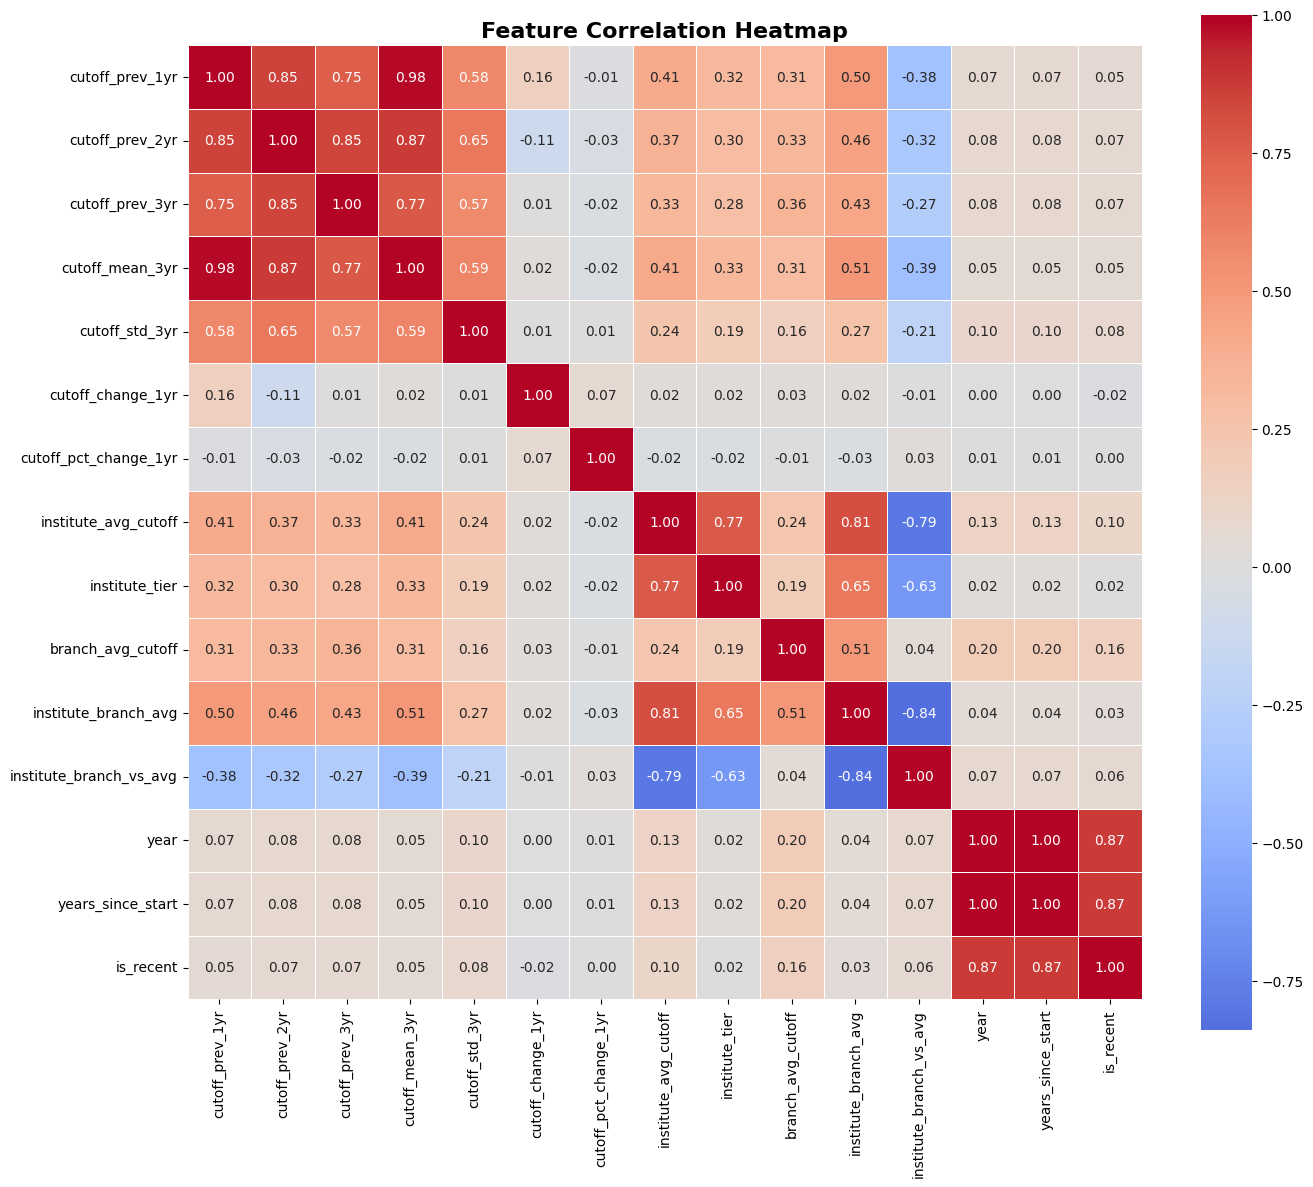


✅ Correlation analysis completed!


In [118]:
# Calculate correlation matrix for numeric features
print("🔄 Analyzing feature correlations...")

# Select only numeric features for correlation
numeric_features = lag_features + statistical_features + aggregate_features + time_features
correlation_matrix = df[numeric_features].corr()

# Find highly correlated pairs (>0.95)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print("\n📊 Highly correlated feature pairs (|correlation| > 0.95):")
if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  - {feat1} ↔ {feat2}: {corr:.3f}")
else:
    print("  ✓ No highly correlated features found!")

# Visualize correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n✅ Correlation analysis completed!")

## Step 12: Data Summary and Statistics

In [119]:
# Summary of engineered dataset
print("📊 FEATURE ENGINEERED DATA SUMMARY")
print("=" * 80)
print(f"Total records: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Total features for modeling: {len(feature_columns)}")
print(f"Target variable: {target_column}")

print("\n" + "=" * 80)
print("📈 Feature statistics:")
print(df[feature_columns].describe())

print("\n" + "=" * 80)
print("✓ Data quality checks:")
print(f"Missing values: {df[feature_columns].isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(f"Infinite values: {np.isinf(df[feature_columns].select_dtypes(include=[np.number])).sum().sum()}")

📊 FEATURE ENGINEERED DATA SUMMARY
Total records: 73,523
Total columns: 29
Total features for modeling: 21
Target variable: cutoff

📈 Feature statistics:
       institute_encoded  branch_encoded  quota_encoded  seat_type_encoded  \
count       73523.000000    73523.000000   73523.000000       73523.000000   
mean           67.550535       60.216136       1.904084           4.095766   
std            38.790246       26.710092       1.784482           2.595146   
min             0.000000        0.000000       0.000000           0.000000   
25%            28.000000       42.000000       0.000000           2.000000   
50%            78.000000       57.000000       3.000000           4.000000   
75%           103.000000       90.000000       4.000000           6.000000   
max           129.000000      132.000000       4.000000           9.000000   

       gender_encoded  branch_demand_category_encoded  cutoff_prev_1yr  \
count    73523.000000                    73523.000000     73398.000000

## Step 13: Save Feature Engineered Data

Save the complete dataset with all features for model training.

In [120]:
# Save the feature-engineered dataset
df.to_csv('cutoffs_features.csv', index=False)

print("✅ Feature-engineered data saved successfully!")
print(f"📁 File: cutoffs_features.csv")
print(f"📊 Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Also save just the features and target for easy loading
df_model = df[feature_columns + [target_column] + ['seat_id', 'institute', 'branch']].copy()
df_model.to_csv('cutoffs_model_ready.csv', index=False)

print(f"\n✅ Model-ready data saved!")
print(f"📁 File: cutoffs_model_ready.csv")
print(f"📊 Shape: {df_model.shape[0]} rows × {df_model.shape[1]} columns")

# Save feature names for reference
feature_info = pd.DataFrame({
    'feature_name': feature_columns,
    'feature_type': (
        ['categorical'] * len(categorical_features) +
        ['lag'] * len(lag_features) +
        ['statistical'] * len(statistical_features) +
        ['aggregate'] * len(aggregate_features) +
        ['time'] * len(time_features)
    )
})
feature_info.to_csv('feature_names.csv', index=False)

print(f"\n✅ Feature metadata saved!")
print(f"📁 File: feature_names.csv")

print("\n" + "=" * 80)
print("🎉 PHASE 2: FEATURE ENGINEERING COMPLETED!")
print("=" * 80)
print("\nReady for Phase 3: Model Building and Training!")
print(f"\nFiles created:")
print(f"  1. cutoffs_features.csv - Full dataset with all features")
print(f"  2. cutoffs_model_ready.csv - Clean dataset ready for modeling")
print(f"  3. feature_names.csv - Feature metadata")

✅ Feature-engineered data saved successfully!
📁 File: cutoffs_features.csv
📊 Shape: 73523 rows × 29 columns

✅ Model-ready data saved!
📁 File: cutoffs_model_ready.csv
📊 Shape: 73523 rows × 25 columns

✅ Feature metadata saved!
📁 File: feature_names.csv

🎉 PHASE 2: FEATURE ENGINEERING COMPLETED!

Ready for Phase 3: Model Building and Training!

Files created:
  1. cutoffs_features.csv - Full dataset with all features
  2. cutoffs_model_ready.csv - Clean dataset ready for modeling
  3. feature_names.csv - Feature metadata
